#  Modèle linéaire généralisé  (Generalize Linear Model)  


***Introduction:*** Nous nous intéressons à la modélisation probabiste de données: Elles sont constituées d'input $x_i$ et d'ouput $y_i$. 

* exemple 1: $y_i$ est le prix du $i$-ième appartement et $x_i$=(surface, ensoleillement, quatier)
* exemple 2: $y_i$ est le nombre d'accident du $i$-ième client d'une assurance, et $x_i$ c'est toutes ses données personnelles.

On va chercher une loi de probabilité qui décrive au mieux la distribution (=la loi) d'un output lorsqu'on observe un input donné. Cette loi pourra dépendre d'un certain paramètre $w$ qu'il faudra ensuite ajuster au mieux. 

***Vocabulaire:***
* input = variable explicative = descripteur = variable exogène 
* output = variable réponse = variable cible = variable endogène 


***Mathématiquement 1:*** On imagine une fonction $L(x,y,w)$ et l'on décrète que la proba d'observer $y_i$ en présence de $x_i$ est:  

$$
	    L( x_i , y_i , w )     \qquad   \qquad  \hbox{ pour un certain } w
$$

En supposant les observations indépendantes, la proba d'observer simultanément $y[0],y[1],y[2]...$ est donc de

$$
	  L(x[0],y[0],w) * L(x[1],y[1],w) * L(x[2],y[2],w) * ... = \prod_i  L( x_i , y_i , w ) 
$$
 
Le meilleur $w$ possible, est naturellement celui qui rend le plus probable (=vraissemblable) nos données, à savoir:

$$
		\hat w = \hbox{argmax}_w \prod_i  L( x_i , y_i , w ) 
$$
ce qu'on reformule souvent comme ceci:
$$
		\hat w = \hbox{argmin}_w - \sum_i  \log L( x_i , y_i , w ) 
$$

Cette manière de choisir $w$  s'appelle: "la technique du maximum de vraissemblance". 



***Mathématiquement 2:*** L'explication précédente est simple, mais elle n'est rigoureuse que lorsque les données sont "discrètes" \[ex: $y_i$ est un nombre d'accident\].  Pour des variables continues \[ex: $y_i$ est le prix d'un appartement\], la probabilité d'observer exactement une donnée en particulier est nulle (en théorie).  

Reformulons notre méthodologie pour la rendre rigoureuse dans tous les cas: On imagine une fonction $L(x,y,w)$, et l'on décrète  que les $y_i$ (petit y) sont des observations de v.a $Y_i$ (grand Y) dont la densité est:

$$
		 y \to  L(x_i,y,w)
$$
Ainsi la densité jointe de $Y_0,Y_1,Y_2...$ c'est
$$
\prod_i  L( x_i , y_i , w ) 
$$
et le paramètre qui rend le plus vraissemblable l'ensemble de nos données est toujours: 
$$
		\hat w =\hbox{argmax}_w \prod_i  L( x_i , y_i , w ) 
$$
La seule différence c'est que la fonction $L$ peut dépasser 1. 


***A quoi ça sert?*** A deux choses:

1/ À comprendre l'influence de l'input $x$  sur l'output $y$. Ex: on pourra en déduire que le prix d'un appartement est une fonction affine de la surface, qu'il dépend exponentiellement de la 'chicosité' du quartier, mais aussi que, plus le quartier est chic, et plus la variance des prix augmente, etc.

2/ À prédire: supposons que l'on dispose d'un input $x'$ qui n'est pas dans nos données initiales; quel est l'output $y'$ qui lui correspondrait le mieux? ex: considérons un appartement $x'$=(surface: 33$m^2$, ensoleillement: sombre, quartier: très chic). Quelle est l'estimation de son prix?. Pour cela on peut prendre:

* le $y'$ qui maximise la vraissemblance $y\to L(x',y,\hat w)$  
* l'espérance de la v.a $Y$ dont la densité est  $y\to L(x',y,\hat w)$ 

On choisi en général la seconde estimation (qui coincide parfois avec la première). 





In [ ]:
""" maintenant on va coder. On importe les libraires utiles."""
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt
np.set_printoptions(linewidth=50000,suppress=True,precision=2)
% matplotlib inline

# Comparaison de deux jeux de données

Observez les points ci-dessous. 

* ressemblance: ils ont la même tendance : plus `x[i]` est grand, et plus `y[i]` est grand, et cette dépendance semble être linéaire. 

* dissemblance: sur le second,  plus `x[i]` est grand, le plus la variabilité des `x[i]` est grande. De plus les `y[i]` sont tous positifs.

On imagine bien qu'il ne faudra pas modéliser ces deux jeux de la même manière. 

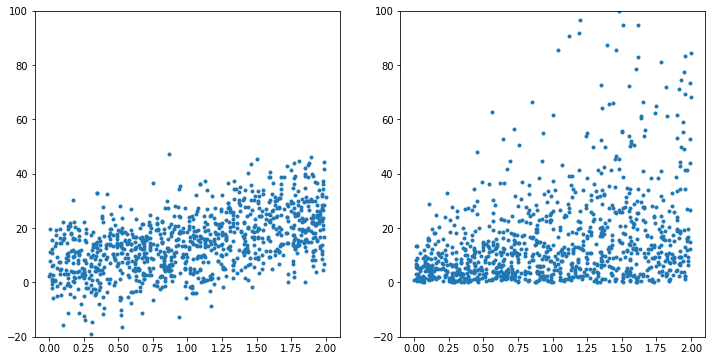

In [2]:
x0=np.loadtxt("data/data0_x.csv")
y0=np.loadtxt("data/data0_y.csv")

x1=np.loadtxt("data/data1_x.csv")
y1=np.loadtxt("data/data1_y.csv")

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x0,y0,'.')
plt.ylim([-20,100])
plt.subplot(1,2,2)
plt.plot(x1,y1,'.')
plt.ylim([-20,100]);


***Exo:*** En utilisant la technique des moindres carrés, calculer avec python la meilleur droite de régression pour ces deux jeux de données. Superposer cette droite avec les données. 

# Le modèle linéaire Gaussien

Considérons le premier jeu de données. Il est bien modélisé par une formule du type

		y[i] = w0 + w1  x[i] + Bruit[i]

Si on suppose en plus que `Bruit[i]` c'est des v.a gaussiennes centrées de variance σ² (qui ne dépend pas de `i`), alors notre modèle est :

         y[i] ~ Normale (esp = μ[i] , var = σ² ),   μ[i] = w0 + w1 x[i]


Remarque: Le second jeu de données serait mieux modélisé par des v.a de loi Gamma : elles sont positives, et leur variance augmente quand l'espérance augmente (quant le paramètre de forme est fixé). On verra cela plus tard. 


Maintenant estimons les paramètres `w0` (=le biais) et `w1` (=la pente de la tendance) en utilisant la librairie `statsmodel` qui utilise la technique du maximum de vraissemblance. 


In [3]:
def estimate_linear_drift(x, y,verbose=False):
    """ on étend les descripteurs `x` en ajoutant une colonne de '1' . Car dans le modèle 
             mu[i]= w0*'1' + w1*x[i] """
    x_ext=np.stack([ np.ones(len(x)) , x],axis=1)
    
    model = sm.GLM(endog=y, exog=x_ext, family=sm.families.Gaussian())
    model_results = model.fit()
    w=model_results.params
    
    if verbose: print(model_results.summary())
    return w

print("estimation de w0 w1:",estimate_linear_drift(x0, y0));



estimation de w0 w1: [ 4.63  9.75]


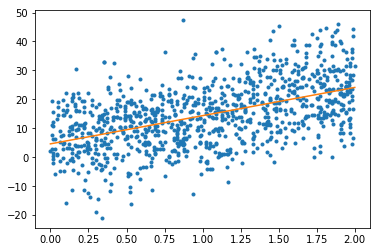

In [4]:
""" traçons cette tendance """
w=estimate_linear_drift(x0, y0)
plt.plot(x0,y0,'.')
xx=np.linspace(np.min(x0),np.max(x0),100)
plt.plot(xx,w[0]+w[1]*xx);

***Exo:***  Calculez la vraissemblance $\prod_i L(x_i,y_i,w)$ dans le modèle gaussien. Ecrivez et simplifiez le problème de maximisation qui permet d'obtenir $\hat w$. Montrez qu'on retrouve la formule des moindres carrés.   

Mais le fait d'avoir ajusté un modèle probabiliste sur les données nous permet de juger de la qualité de nos estiamtions. Observons le "summary" fourni par `statsmodel`: 

In [5]:
estimate_linear_drift(x0, y0,verbose=True);

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                   90.9263687696
Method:                          IRLS   Log-Likelihood:                -3673.0
Date:                Wed, 06 Jun 2018   Deviance:                       90745.
Time:                        09:34:04   Pearson chi2:                 9.07e+04
No. Iterations:                     2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6305      0.613      7.557      0.000       3.430       5.832
x1             9.7461      0.519     18.770      0.0

Observons la ligne "const" ci dessus: 

* `coef`  c'est $\hat w_0$: le terme constant de notre droite de regression, qui approxime le "vrai" $w_0$. On l'appel aussi "biais" ou "intercept". 
* `std err` c'est l'écartype estimé de l'estimateur $\hat w_0$.
* `\[0.025  0.975\]` c'est l'intervalle de confiance à 95%. Le vrai paramètre $w_0$ appartient à cet intervalle avec une probabilité de 95%. 
* `P>|z|`   c'est la p-value associé au test de nullité de $w_0$. Rappelons simplement la recette: 
1/ On choisit un niveau de test, disons $\alpha=5\%$.
2/ Quand `p-value[j]`$<\alpha$, on choisi l'hypothèse H1 c.à.d qu'on décrète que `w[j]` est non-nul.
3/ Quand `p-value[j]`$>\alpha$, on choisi l'hypothèse H0 c.à.d qu'on décrète que `w[j]` est nul, donc les input `x[:,j]` n'ont pas d'influence sur l'output. On a toujours intérêt à enlever des inputs inutiles car ils parasitent l'interprétation des résultats. 

### Résidus

Reprenons nos deux jeux de données.

Les résidus ce sont les données `y[i]` moins l'estimation `mu[i]=b+w X[i]` (graphiquement :on soustrait aux points la droite de tendance). Quand le modèle linéaire gaussien est (approximativement) le bon, les résidus ont (approximativement) une distribution gaussienne. 

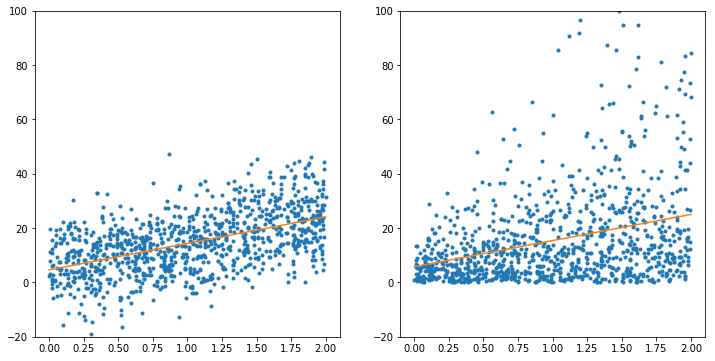

In [6]:
w0=estimate_linear_drift(x0, y0)
w1=estimate_linear_drift(x1, y1)

xx=np.linspace(np.min(x0),np.max(x0),100)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(x0,y0,'.')
plt.plot(xx,w0[0]+w0[1]*xx);
plt.ylim([-20,100])

plt.subplot(1,2,2)
plt.plot(x1,y1,'.')
plt.plot(xx,w1[0]+w1[1]*xx);
plt.ylim([-20,100]);



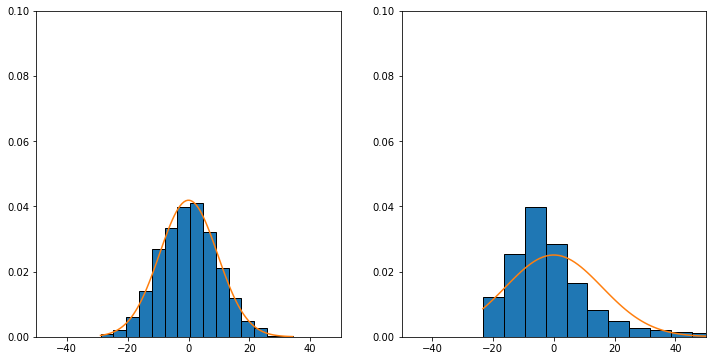

In [7]:
def plot_residus(x,y):
    b,w=estimate_linear_drift(x, y)
    residus=  (y   -  b - w* x)
    """ histogramme des résidus """
    plt.hist(residus,bins=15,edgecolor="k",normed=True)
    """ on ajuste par dessus une courbe gaussienne. """
    xx=np.linspace(np.min(residus),np.max(residus),100)
    yy=stats.norm.pdf(xx,scale=np.std(residus))
    plt.plot(xx,yy)
    plt.xlim(-50,50)
    plt.ylim(0,0.1)
    
    
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_residus(x0,y0)
plt.subplot(1,2,2)
plot_residus(x1,y1)    

Pour le second jeu de donnée, l'hypothèse de résidu gaussien semble fausse. Pour aller au delà d'un test visuel, il existe des tests de gaussianité.

# Modèle log-Gamma 


Observons un nouveau jeu de données :

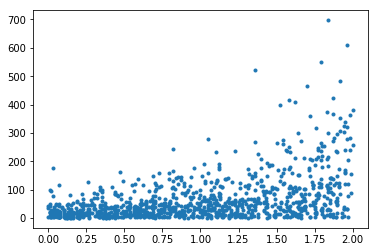

In [8]:
x2=np.loadtxt("data/data2_x.csv")
y2=np.loadtxt("data/data2_y.csv")
plt.plot(x2,y2,'.');

Il semble que les input `x[i]` ont un effet sur-linéaire sur les output `y[i]`. On pourrait alors imaginer que 

	Y[i] ~ Normale (esp = μ[i] , var = σ² )  avec   μ[i]= exp(w0+ w1*X[i])


Mais ce n'est encore une bonne modélisation: car sur les observations, plus `x[i]` est grand et plus la variance de `y[i]` est grande. De plus les données sont positives. Le choix naturel est alors:  

    Y[i] ~ Gamma(shape = α,  scale = μ[i]/ α)    avec  μ[i] = exp(w0+ w1*x[i] )

En effet, la loi gamma a deux paramètres `shape` et `scale`, et son espérance c'est le produit de ces deux paramètres. 


***Vocabulaire et remarques:*** la fonction 'lien' est l'inverse de la fonction qui relie l'input à l'espérance des données modélisées. Donc ici la fonction 'lien' est le log. 

Cherchez dans le code ci-dessous l'endroit où l'on précise cette fonction 'lien'. Remarquez aussi que l'on ne précise pas le paramètre de forme `α`: car il n'intervient pas dans la maximisation (tout comme la variance σ² dans le modèle linéaire).  


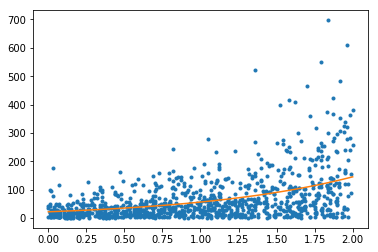

In [9]:
def estimate_exponential_drift(x, y):
    x_ext=np.stack([ np.ones(len(x)) , x],axis=1)
    model = sm.GLM(endog=y, exog=x_ext, family=sm.families.Gamma(link=sm.families.links.log))
    model_results = model.fit()
    w=model_results.params
    return w

w=estimate_exponential_drift(x2,y2)
plt.plot(x2,y2,'.')
xx=np.linspace(0,2,100)
plt.plot(xx,np.exp(w[0]+w[1]*xx));


***Exo:*** La bibliothèque statsmodel a encore une fois utilisé la technique du maximum de vraissemblance. Ecrivez la vraissemblance $\prod_i L(x_i,y_i,w)$ en utilisant le fait que la densité de Gamma(shape = α, scale = 1) est :
$$
 y \to     \frac 1 {\Gamma(\alpha)}     y ^{\alpha-1} e^{- y} 
$$
(comme d'habitude, pour passer de scale = 1 à scale = θ on change y en y/θ et l'on multiplie la densité par 1/θ pour que l'intégrale reste égale à 1)

Ecrivez le problème de maximisation, simplifiez-le, vérifier que le paramètre de forme $\alpha$ n'intervient pas dans l'expression de $\hat w$. 




# Modèle log-Poisson


Observons de nouvelles données. L'output `y[i]` sont le nombre d'accident de l'individu `i`, l'input est `x[i]` est "l'indice fangio" de ce même individu. 

Remarque: l'output est maintenant à valeur entière, mais cela reste une donnée quantitative. 

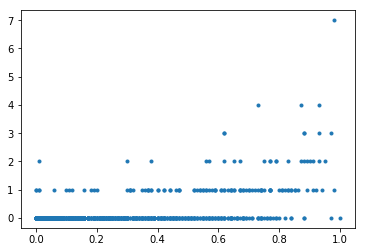

In [10]:
x=np.loadtxt("data/accident_x.csv")
y=np.loadtxt("data/accident_y.csv")
plt.plot(x,y,'.');

Les `y[i]` sont discrets. La majorité des individus ont 0 accident, mais ceux avec un grand indice fangio peuvent avoir de nombreux accidents, le reccord étant 7!   On suppute que l'"indice fangio" a un effet multiplicatif sur la fréquence des accidents. Le modèle naturel est :  

        Y[i] ~ Poisson (λ = μ[i]),  avec   μ[i]= exp(w0+ w1*X[i])
    
On rappelle que l'espérance de la loi de Poisson, c'est son paramètre λ. 

Nous utilisons `statsmodel` pour estimer les paramètres `w0` et `w1`. Pour le modèle Poissonien,  la fonction de lien "par défaut" est la fonction log, donc nous n'avons pas besoin de la préciser dans le code ci-dessous. 

In [11]:
x_ext=sm.add_constant(x)
model = sm.GLM(endog=y, exog=x_ext,  family=sm.families.Poisson())
res = model.fit()
w=res.params
print("estimation de w0 et w1:",w)

estimation de w0 et w1: [-4.02  5.03]


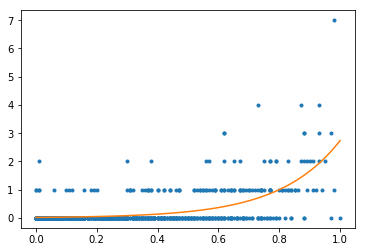

In [12]:
plt.plot(x,y,'.')
xx=np.linspace(0,1,100)
plt.plot(xx,np.exp(w[0] + w[1]*xx ) );

### Modèle avec exposition

Dans les données précédentes, le nombre d'accident était observer sur une période donnée commune à tous les clients (1 an). 

Dans les données suivantes, on observe les clients sur des durées variables. On a donc deux inputs:  

1/ l'indice fangio
2/ l'exposition (=la durée d'observation) qui est donnée en nombre de jour

On voit naturellement que plus la durée d'observation est longue, et plus le nombre d'accident est important. 

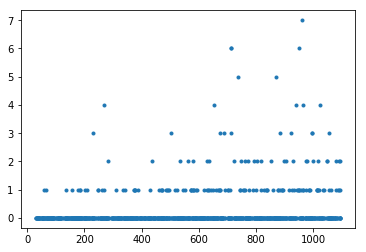

In [13]:
xt=np.loadtxt("data/accident_exposure_x.csv")
x=xt[:,0] #indice fangio
t=xt[:,1] #exposition
y=np.loadtxt("data/accident_exposure_y.csv")
plt.plot(t,y,'.');

Il est donc naturelle de diviser le nombre d'accident par l'exposition. On obtient ainsi un nouvel output `y/t`  que l'on peut essayer d'observer en fonction de l'indice fangio. On retombe alors sur un graphique similaire à celui du premier jeu de donnée d'accident.   

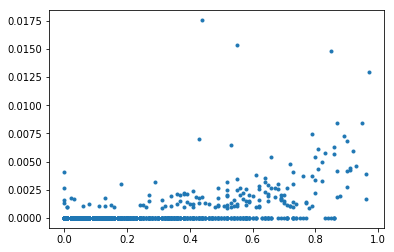

In [14]:
plt.plot(x,y/t,'.');

On pourrait alors imaginer comme modèle: 

        Y[i]/t[i] ~ Poisson (λ = μ[i]),  avec   μ[i]= exp(w0+ w1*X[i])

Mais ce n'est pas terrible (notamment car `Y/t` n'est pas un entier). Le bon modèle dans ce cas est:

         Y[i] ~ Poisson (λ =  μ[i]),  avec   μ[i]= t[i] exp(w0+ w1*X[i]) = exp(w0+ w1*X[i]+ log(t[i]) )

On voit apparaire l'input `log(t[i])` dans l'exponentielle. C'est une variable dite "offset" car on ne cherche pas à lui associé un coefficient `w`. Observez comment on rajoute une variable offset dans `statsmodel`


In [15]:
x_ext=sm.add_constant(x)
model = sm.GLM(endog=y, exog=x_ext,  family=sm.families.Poisson(),offset=np.log(t))
res = model.fit()
w=res.params
print("estimation de w0 et w1:",w)

estimation de w0 et w1: [-10.04   5.17]


***Exo:*** Les clients entre les deux jeux de données sont les mêmes. Dans le premier jeu, on avait simplement considéré des clients sur une période de 1 an.  

Par un petit calcul, justifiez que l'intercep `w0` soit environ -4 dans le premier jeu  et -10 dans le second jeu.  

# Modèle logistique pour la classification binaire 


Les jeux de données vont maintenant changer de nature: la variable output sera une variable qualitative et non plus quantitative. On aura donc affaire à des problèmes de classification et non plus de régression. 

Comme auparavant, on va essayer de trouver une bonne loi pour nos observations. 

### données individuelles

Dans le jeu de données suivant, chaque ligne représente une bactérie. Il y a 2 input (car `x` a 2 colonnes). Leur signification est:

*  `x1[i]` : quantité de nouriture donnée à la bactérie `i` (en calories)
*  `x2[i]` : quantité de d'oxigène donnée à la bactérie `i` (en litres)    

L'output est binaire:

* `y[i]=0` : la bactérie `i` est morte
* `y[i]=1` : la bactérie `i` est vivante

Observons les données:
   

matrice des inputs (transposée)
[[ 2.7   0.69  2.09  2.03  0.67  3.74  2.61  4.08  2.85  3.18]
 [ 2.54  4.54  4.1   1.86  3.21  1.76  1.87  3.36  0.62  0.82]]
vecteur des outputs
[ 1.  0.  1.  0.  0.  1.  0.  1.  0.  1.]


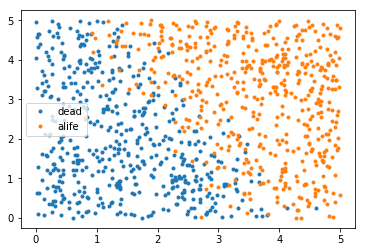

In [16]:
x=np.loadtxt("data/bacteria_alone_x.csv")
y=np.loadtxt("data/bacteria_alone_y.csv")

print("matrice des inputs (transposée)")
print(x[:10].T)
print("vecteur des outputs")
print(y[:10])

x_dead=x[y==0]
x_alife=x[y==1]
plt.plot(x_dead[:,0],x_dead[:,1],".",label="dead")
plt.plot(x_alife[:,0],x_alife[:,1],".",label="alife")
plt.legend();


Nous aimerions connaître l'effet des inputs sur la probabilité de survie des bactéries. Nous supposons alors que l'output a la loi suivante :
	
	  Y[i] ~  Bernoulli(p = μ[i] ),  μ[i] =  sigmoid(w . x[i])

avec 
* `sigmoid(t) = exp(t) / (1 + exp(t))` est une fonction croissante qui a le bon goût d'arriver dans \[0,1\], ce qui fournit donc une probabilité. 
*  `w =(w[0],w[1],w[2])` est un vecteur de 3 paramètres. Le premier paramètre `w[0]`est le biais (='intercept')
*  `w . x[i]` est le produit scalaire entre `w` et la i-ième ligne de l'input `x`. Attention, il s'agit de l'input étendu `x[i,:]=(1,x1[i],x2[i])`




In [17]:
""" on ajoute une colonne de 1 (on pourrait aussi utiliser np.concatenate)"""
x=sm.add_constant(x)

glm = sm.GLM(endog=y, exog=x,  family=sm.families.Binomial())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      997
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -170.81
Date:                Wed, 06 Jun 2018   Deviance:                       341.63
Time:                        09:34:09   Pearson chi2:                     889.
No. Iterations:                     8                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.2051      1.106    -12.845      0.000     -16.373     -12.038
x1             3.6980      0.285     12.981      0.000       3.140       4.256
x2             2.0054      0.177     11.314      0.000       1.658       2.353
==============================================================================
"""

`statmodel` nous indique que les  paramètres qui maximisent la vraisemblance des données sont approximativement:

	w = [-14.2,3.6,2.0]

***Exo:*** supposons que l'on ait une bactérie que l'on a nourrit avec 3 callories et 0.5 littre d'oxigène. Quelle est sa probabilité de survie?  

*** A vous:***  

Découpez le jeu de données en 2 parties. Une partie `train` (800 lignes) et une partie `test` (200 lignes). Vous obtiendrez ainsi 2 matrices `x_test` et `x_train` et 2 vecteurs `y_test` et `y_train` 

Estimez `w` à partir du jeu train. Puis pour chaque élément du jeu `test` estimez une probabilité de survie `hat_y_test_proba`.  Calculez:  

	hat_y_test = (hat_y_test_proba>0.5)

comparez `hat_y_test` et `y_test`






### Données groupées


Dans le jeu de données suivant, chaque ligne représente un lot bactérie. Les inputs ont la même signification: quantité de nourriture, quantité d'oxygène (par bactérie). Mais maintenant la sortie comporte deux colonnes:  

* `y[i,0]` : nombre de bactérie vivante dans le lot `i` 
* `y[i,1]` : nombre de bactérie morte dans le lot `i`

Observons les 10 premiers lots de bactéries...
   



In [18]:
x=np.loadtxt("data/bacteria_grouped_x.csv")
y=np.loadtxt("data/bacteria_grouped_y.csv")

print("matrice des inputs (transposée)")
print(x[:10].T)
print("matrice des outputs (transposée)")
print(y[:10].T)


matrice des inputs (transposée)
[[ 1.82  3.84  2.39  3.62  0.32  4.14  1.66  0.56  1.91  1.9 ]
 [ 2.95  2.3   2.86  3.86  4.02  0.07  3.09  1.65  3.38  3.59]]
matrice des outputs (transposée)
[[  2.  10.   4.   8.   0.   4.   1.   0.   1.   4.]
 [  4.   0.   3.   0.   5.   1.   8.  10.   6.   2.]]


Il est naturel de reprendre le modèle précédent, mais en remplaçant la bernoulli par une binomiale:	

		Loi(Y[i,0]) = Binomiale(n[i] , p = μ[i] ),     μ[i] =  sigmoid(w . x[i]) ,  n[i]= Y[i,0]+Y[i,1]

Voici ce que donne l'estimateur de maximum de vraissemblance...

In [19]:
x=sm.add_constant(x)
glm = sm.GLM(endog=y, exog=x,  family=sm.families.Binomial())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ['y1', 'y2']   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      997
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -557.92
Date:                Wed, 06 Jun 2018   Deviance:                       528.92
Time:                        09:34:10   Pearson chi2:                     92.1
No. Iterations:                     8                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.3275      0.456    -33.639      0.000     -16.221     -14.434
x1             4.0739      0.119     34.322      0.000       3.841       4.307
x2             2.0445      0.068     29.909      0.000       1.910       2.178
==============================================================================
"""

### Analyse d'un vrai jeu de donnée

Nous allons étudier un jeu de données inclus dans `statsmodel`. Toutes les informations sur ces données sont disponibles en effectuant:
```python
	print(sm.datasets.star98.NOTE)
```

On y découvre qu'il y a:
* 303 lignes, chaque ligne correspondant à un "county" (=zone géographique) de californie. 
* 13 variables auquelles s'ajoutent 8 variables  d'interaction (= des combinaisons des 13 premières). 

Parmis ces 13 variables, les 2 premières sont l'output qui nous intéresse:
* nb étudiant > médiane nationale  (pour chaque county)
* nb étudiant < médiane nationale (pour chaque county)

Les autres variables seront nos inputs, on y trouve notamment:
* pourcentage d'étudiant par minorité ethnique (Asian,black,hispanic)
* ratio étudiant/prof
* pourcentage d'étudiant de faible revenu (low income)

Nous allons voir l'influence des revenus sur la réussite des études. 


In [20]:

data = sm.datasets.star98.load()
print("data.exog.shape",data.exog.shape)
print("data.endog.shape",data.endog.shape)
print("data.endog_name",data.endog_name)
print("data.exog_name",data.exog_name)

    

data.exog.shape (303, 20)
data.endog.shape (303, 2)
data.endog_name ['NABOVE', 'NBELOW']
data.exog_name ['LOWINC', 'PERASIAN', 'PERBLACK', 'PERHISP', 'PERMINTE', 'AVYRSEXP', 'AVSALK', 'PERSPENK', 'PTRATIO', 'PCTAF', 'PCTCHRT', 'PCTYRRND', 'PERMINTE_AVYRSEXP', 'PERMINTE_AVSAL', 'AVYRSEXP_AVSAL', 'PERSPEN_PTRATIO', 'PERSPEN_PCTAF', 'PTRATIO_PCTAF', 'PERMINTE_AVYRSEXP_AVSAL', 'PERSPEN_PTRATIO_PCTAF']


On s'apperçoit qu'il y a en fait 20+2 variables (alors que  la description en annonçait 13+8 ?!). 

Nous prenons comme descripteur tout le tableau `data.exog`. Une meilleure stratégie serait de créer nous même nos input : par exemple, ne pas prendre les intéractions proposées, et de recréer nous même des interactions qui nous semble significatives.  

***A vous:*** analyser le programme suivant. 
 

In [21]:
data = sm.datasets.star98.load()
x = data.exog
""" on rajoute la constante à la fin, ainsi la variable zéro sera 'LOWINC' =pourcentage d'étudiant ayant un faible revenu """
x = sm.add_constant(x,prepend=False)
y = data.endog


""" le descripteur d'un étudiant 'moyen'  """
means = x.mean(axis=0)
print("means\n",means)


""" et voici l'étudiant 'moyen'  mais qui gagne peu d'argent """
means25 = means.copy()
means25[0] = stats.scoreatpercentile(x[:, 0], 25)
print("means of exog\n",means25)

""" et voici l'étudiant moyen mais qui gagne pas mal d'argent """
means75 = means.copy()
means75[0]  = stats.scoreatpercentile(x[:, 0], 75)


model = sm.GLM(endog=y, exog=x, family=sm.families.Binomial())
res = model.fit()

resp_25 = res.predict(means25)
resp_75 = res.predict(means75)
diff = resp_75 - resp_25
""" que signifie cette différence ? Le signe 'moins' ne vous semble-t-il pas contre intuitif ?
"""
print("diff:",diff) 

means
 [    41.41      5.9       5.64     34.4      14.69     14.25     58.64      4.32     22.46     33.63      1.18     11.61    209.02    879.98    839.72     96.3     147.24    747.45  12585.27   3243.61      1.  ]
means of exog
 [    26.68      5.9       5.64     34.4      14.69     14.25     58.64      4.32     22.46     33.63      1.18     11.61    209.02    879.98    839.72     96.3     147.24    747.45  12585.27   3243.61      1.  ]
diff: [-0.12]


***Exo:*** critiquez cette étude. Mathématiquement: n'y a-t-il pas un problème avec les variables d'interaction ?  Sociologiquement: est-ce que la variable revenus ("incomes") est un bon indicateur pour savoir si l'étudiant finance facilement ses études?

### Exo:

Ci-dessous : 

* x: nombre d'heure de travail
* y: réussite de l'intéro. 

Quelle est la probabilité de réussite si je travaille 5 minutes ? 1 heure ?

Quelle est le minimum de travail à fournir si je veux avoir 50% de chance de réussir ?

In [22]:
x=[2.427, 1.474, 0.396, 1.009, 3.424, 0.068, 4.682, 2.892, 3.351, 2.229, 1.78, 4.742, 2.184, 1.326, 3.446, 0.176,
     0.549, 1.919, 0.096, 1.378, 3.483, 0.309, 0.857, 1.079, 0.386, 1.02, 2.882, 1.538, 3.628, 3.812, 0.602, 2.423,
     3.109, 0.996, 0.202, 0.975, 1.645, 2.082, 1.114, 2.442, 0.486,
     1.5, 3.827, 3.235, 4.192, 1.716, 1.969, 0.385, 1.371, 2.044, 4.498, 0.361, 2.053, 4.866, 4.136, 3.646, 1.475, 4.907, 0.532, 4.984, 1.834, 2.19, 1.758, 0.713, 1.45, 3.342, 2.125, 4.293, 3.691, 3.189, 1.416, 0.531, 3.111, 3.505, 2.498, 0.888, 2.861, 3.741, 1.956, 1.879, 0.942, 4.699, 4.932, 1.875, 2.023, 2.473, 4.438, 2.781, 2.348, 4.696, 2.708, 1.392, 2.221, 4.882, 1.679, 4.936, 0.104, 0.224, 2.685, 1.662]
y=[1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
     1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1];


# Modèle multinomial pour la classification multi-classes

Dans le jeu suivant l'output `Y` peut avoir 7 valeurs différentes, chaque valeur correspondant à un type de verre. On est donc en présence d'un problème de classification à 7 classes.  Les inputs sont les composants chimiques présents dans le verre, ainsi que l'indice de réfraction `RI`.  


Considérons un vecteur `p=[p[0],...,p[6]]` notons  

        Y ~  MultiBernoulli(p)   <=>  P[Y=k]= p[k]

C'est la loi la plus simple qui couvre 7 valeurs différentes. On aurait aussi pu la noter `Multinomiale(1,p)`. 

Le modèle naturel pour nos données est:
        
		Y[i] ~ MultiBernoulli(p=μ[i,:]),      μ[i,:] =  solftmax( w . x[i])     
où
* `μ[i,:]` est le vecteur des probabilités des 7 classes relatives à la donnée `i`. 
*   `w` est une matrice de paramètre de taille nbClasses × nbInputs. Ainsi le produit matriciel `w . x[i]` donne un vecteur de taille nbClasses=7 
* solftmax est une fonction transformant n'importe quel vecteur $v$   en un vecteur de probabilité :
$$
        \verb $solftmax$( [v_0,...,v_6] )\ \ = \ \  \Big[ \frac {e^{v_0}}{C},...,\frac {e^{v_6}}{C}    \Big] ,  \qquad 
        C=  {e^{v_0}} + ... +  {e^{v_6}}
$$
La vraissemblance est extrèmement simple, et le maximum de vraissemblance donne: 
$$
\hat w  = \hbox{argmax}_w  \prod_i    \Big (  \verb IsoftmaxI (W\cdot x_i)  _{y_i}    \Big)
$$
(on se souvient que $\verb IsoftmaxI (W\cdot x_i)$ est un vecteur de taille nbClasses, et que $y_i$ est l'indice de la classe associée à l'input $x_i$)

Observons les données. Nous utilisons pour cela pandas qui crée une dataframe: une matrice avec des noms pour les colonnes.  

In [23]:
glass_data_headers = ["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "glass-type"]
glass_data = pd.read_csv("data/glass.csv", names=glass_data_headers)
glass_data.head(10)

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,glass-type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [24]:
""" observons la répartition des classes de verre """
vc=glass_data['glass-type'].value_counts(dropna=False)
""" cela donne un dictionnaire, que nous affichons en le classant """
for key,value in sorted(vc.items()):
    print("classe:",key,"effectif:",value)

classe: 1 effectif: 70
classe: 2 effectif: 76
classe: 3 effectif: 17
classe: 5 effectif: 13
classe: 6 effectif: 9
classe: 7 effectif: 29


Nous allons ajuster deux modèles. Nous leur ferons ensuite prédire des types de verre. 

* le premier modèle est le modèle multiBernouilli (=multinomial) décrit précédemment
* le second modèle est le modèle logistique-généralisé: le modèle logistique de base prédit des probilités pour 2 classes (classification binaire). Il se généralise ainsi: on teste chacune des classes contre l'ensemble de toutes les autres; on garde à la fin la classe qui obtient la meilleure probabilité (même si cette probabilité est <0.5). 






In [25]:
""" on utilise le module sklearn et non plus statsmodel """
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import metrics

x=glass_data[glass_data_headers[:-1]]
y=glass_data[glass_data_headers[-1]]

train_x, test_x, train_y, test_y = train_test_split(x,y, train_size=0.7)


# modèle multinomial
""" on doit aussi précisser un solveur (=la technique pour trouver le maximum de vraissemblance). Tout ceci est bien
expliqué sur la page de sklearn"""
model_1 = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
model_1.fit(train_x, train_y)


# modèle logistique généralisé au multi-classes
model_2 = linear_model.LogisticRegression()
model_2.fit(train_x, train_y)


print("model_1 Accuracy : ", metrics.accuracy_score(test_y, model_1.predict(test_x)))
print("model_2 Accuracy : ", metrics.accuracy_score(test_y, model_2.predict(test_x)))


model_1 Accuracy :  1.0
model_2 Accuracy :  0.8


L'accuracy (pourcentage de bien classé) est extrèmement bonne. C'est très suspect! Mais il y a une grosse erreur de méthodologie dans le programme précédent (erreur que l'on rencontre très souvent sur les tutos qu'on trouve en ligne). Corrigez-la!

Aide: observez-bien les input. 

***Remarque:*** ci-dessus, on a utilisé la librairie `sklearn` et non plus `statsmodel`. On est ainsi passé de la communauté des statisticiens à la communauté des datascientist. Ces derniers préfèrent des techniques qui s'éloignent de l'interprétation probabiliste. Par exemple, en voyant la formule ci-dessous: 
$$
\hat w  = \hbox{argmin}_w  \sum_i -\log   \Big (  \verb IsoftmaxI (W\cdot x_i)  _{y_i}    \Big)
$$
le datascientist pensera minimiser une distance cross-entropie, alors que le statisticien verra un maximum de vraissemblance en la reformulant comme ceci: 
$$
\hat w  = \hbox{argmax}_w  \prod_i    \Big (  \verb IsoftmaxI (W\cdot x_i)  _{y_i}    \Big)
$$

# Conclusion

Nous avons effectué:
* de la regression = output quantifatif
* de la classification = output qualitatif

Nous avons modélisé chacun des jeux de données par des v.a dont la loi nous semblait naturelle; ces lois dépendant d'un paramètre $w$. Parmis tous les $w$ possibles nous choisissions le $\hat w$ qui rendait le plus vraissemblable les données observées.   

***Ce n'est pas fini:***  Nous n'avons considéré que des cas d'école, où tous les inputs étaient quantitatifs. Il nous faut encore apprendre à: 
* gérer les input qualitatifs. Par exemple: le sexe du conducteur pour l'assureur, le nom du quartier pour l'agent immobilié.  Ces variable qualitatives ont très souvent des effets multiplicatifs sur l'output. 
* retraiter les input (valeurs abhérantes, valeurs manquante, ordre de grandeurs trop important)
* sélectionner des inputs (ex: avec la p-value), sélectionner des modèles (ex: pénalisation)
* rajouter/modifier des inputs
* juger la qualité d'ajustement d'un modèle

***Pour aller plus loin 1:*** Il y avait un point commun à toutes les lois utilisées précédemment: elles appartiennent à la famille "exponentielle"; une famille qui contient presque toutes les lois usuelles (discrètes et continues) avec comme exception notoire: la loi uniforme. Vous pouvez vous renseigner sur cette famille exponentielle, elle permet de donner un cadre théorique commun à tous les algorithmes que nous avons fait tourner pour estimer $w$.  

***Pour aller plus loin 2:***  Si vous voulez faire le pont entre la communauté des statisticiens et celle des datascientists, voici quelques explications supplémentaires. Pour construire un modèle un datascientist tentera de trouver une fonction $f(x,w)$ qui, pour un certain $w$, modélise le lien entre $x$ et $y$. Il règlera le paramètre $w$ en choisissant une distance $dist$ puis en cherchant:
$$
\hat w  = \hbox{argmin}_w  \sum_i  dist \Big( f(x_i  ,w) , y_i \Big)  
$$
La fonction $x \to f(x,\hat w)$ permettra finalement de faire de la prédiction. 

Maintenant, s'il cherche une densité à coller sur les données, il fera plutôt:
$$
\hat w  = \hbox{argmin}_w  \sum_i  dist \Big( L (x_i, \cdot  ,w) , y_i \Big)  
$$
où la $dist$ est une distance entre une densité $y \to L (x_i,  y  ,w)$ et une observation $y_i$ (ex: cette distance est petite si la densité est une cloche resserrée autour de l'observation). 
En particulier, en prenant comme distance la distance crossEntropique, à savoir:
$$
 dist \Big( L (x_i, \cdot  ,w) , y_i \Big)    =  -\log L(x_i,y_i,w) 
$$
On voit facilement que le problème minimisation ci-dessus est exactement la technique du maximum de vraissemblance décrite dans l'introduction; la fonction log permettant de passer de $\prod$ à $\sum$. 


Bien entendu, de nombreuses techniques de datascience et/ou de statistique sortent de ce cadre. Citons par exemple la technique des $k$-plus proches voisins, dans laquelle on ne cherche pas du tout à inventer une distribution pour nos données; on se contente de faire de la prédiction: quand on dispose d'un nouvel output $x'$, on choisis $y'$ comme étant le "barycentre" des $k$ ouputs $y_i$ correspondant aux $x_i$ proches de $x'$.  

